In [53]:
'''
Import the needed packages
'''

import pandas as pd
import scipy.io
import numpy as np

from IPython.display import Image
import glob
import os

import cv2
import json
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm

In [54]:
'''
This function define coefficients of the
multiplication of the linear combination of the matrix
p = the coordinates of the pixels
cols = the target colors of the pictures
'''
def coefs(p, cols):
    ds = []
    for v in cols:
        d = np.sqrt((p[0]/p[1]-v[0]/v[1])**2+(p[2]/p[1]-v[2]/v[1])**2)
        ds.append(d)
    ds = np.array(ds)
    if (ds==0).any():
        return (ds==0).astype(int)
    dd = ds.sum()/ds
    k = dd/dd.sum()
    return k

In [55]:
'''
Function to takes the images and computes the weighted sum of all matrices for 
every pixels, which then transformed the resulting pixels into images
'''
def process_pic(target_img, img_files, gt, img_colors, img_matrices, M_a):
    copy=img_files[target_img].copy()
    for x in range(copy.shape[0]):
        for y in range(copy.shape[1]):
            p = copy[x, y]
            k = coefs(p, list(img_colors[target_img].values()))
            m_ncb = sum([k[i]*list(img_matrices[target_img].values())[i] for i in range(len(k))])
            copy[x, y] = np.dot(m_ncb, p)
    return copy

In [56]:
'''
Function to process the set of images in a folder, given the ground trugth, 
using the selected color coordinates defined in the json to transform them
'''
def process_folder(dirname, gt_name, out_dir):
    with open(os.path.join(dirname,"images.json")) as f:
        j=json.load(f)
    img_id_file = {x['id']: x['file_name'] for x in j['images']}
    colors_id = {x['id'] : x['name'] for x in j['categories']}
    img_rects = {x: {} for x in img_id_file.values()}
    for ann in j['annotations']:
        img_rects[img_id_file[ann['image_id']]][colors_id[ann['category_id']]] = [int(x) for x in ann['bbox']]
    img_colors = {x: {} for x in img_rects.keys()}
    img_files = {}
    for f, v in img_rects.items():
        img = cv2.imread(os.path.join(dirname,f))
        img_files[f] = img/255
        for c, b in v.items():
            cut = img[b[1]:(b[1]+b[3]+1), b[0]:(b[0]+b[2]+1)]
            img_colors[f][c] = np.median(cut, axis=(0,1))/255
    palette = np.array([[(y*255).astype(int)[::-1] for y in x.values()] for x in img_colors.values()])
    io.imshow(palette)
    gt = img_colors.pop(gt_name)
    M_a = np.array([[0.8951,0.2664,-0.1614],
              [-0.7502,1.7135,0.0367],
              [0.0389,-0.0685,1.0296]])
    #M_a = np.eye(3)
    img_matrices = {x: {} for x in img_colors.keys()}
    for n, v in img_colors.items():
        for col, coord in v.items():
            img_matrices[n][col] = np.linalg.inv(M_a)*((gt[col]/img_colors[n][col])*np.eye(3))*M_a
    for n in tqdm(img_files.keys()):
        if n != gt_name:
            res = (process_pic(n, img_files, gt, img_colors, img_matrices, M_a)*255).astype(int)
            cv2.imwrite(os.path.join(out_dir, n), res)

In [57]:
imdir = '.\images_b'

D:\Program Files\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
  7%|▋         | 1/14 [00:04<00:55,  4.23s/it]


KeyboardInterrupt: 

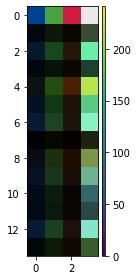

In [58]:
process_folder(imdir, 'gt.jpg', os.path.join(imdir,"resultb"))

In [59]:
'''
Normalization function to scale the vector to unit length
'''
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [60]:
'''
Evaluation funtion to take the targets colors and compares to the ground truth colors
It calculate the average error for each color
'''
def eval_result(dirname, gt_name):
    with open(os.path.join(dirname,"images.json")) as f:
        j=json.load(f)
    img_id_file = {x['id']: x['file_name'] for x in j['images']}
    colors_id = {x['id'] : x['name'] for x in j['categories']}
    img_rects = {x: {} for x in img_id_file.values()}
    for ann in j['annotations']:
        img_rects[img_id_file[ann['image_id']]][colors_id[ann['category_id']]] = [int(x) for x in ann['bbox']]
    img_colors = {x: {} for x in img_rects.keys()}
    img_files = {}
    for f, v in img_rects.items():
        img = cv2.imread(os.path.join(dirname,f))
        img_files[f] = img/255
        for c, b in sorted(v.items()):
            cut = img[b[1]:(b[1]+b[3]+1), b[0]:(b[0]+b[2]+1)]
            img_colors[f][c] = np.median(cut, axis=(0,1))/255
    palette = np.array([[(y*255).astype(int)[::-1] for y in x.values()] for x in img_colors.values()])
    #print(palette.shape)
    io.imshow(palette)
    gt = img_colors.pop(gt_name)
    img_accuracies = {x: {} for x in img_colors.keys()}
    for f, v in img_colors.items():
        for col, val in v.items():
            img_accuracies[f][col] = np.degrees(np.arccos((normalize(gt[col])*normalize(val)).sum()))
    arr = pd.DataFrame(img_accuracies).T.apply(["mean", "std"]).T
    arr.index = arr.index.astype(int)
    return arr.sort_index()

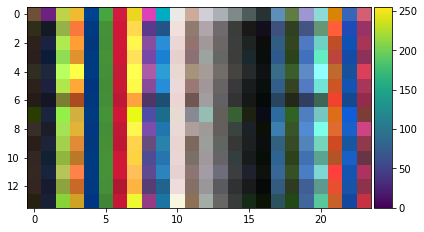

In [61]:
res2 = eval_result(os.path.join(imdir,"resultb"), 'gt.jpg')

In [48]:
res2

,mean,std
1,7.496292,7.005528
2,2.824718,2.256745
3,5.835723,1.845949
4,4.997954,4.071316
5,11.937199,2.167273
6,4.399494,2.167435
7,14.178818,3.887305
8,8.963187,1.446930
9,6.627015,2.362526
10,23.302247,3.567260


D:\Program Files\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


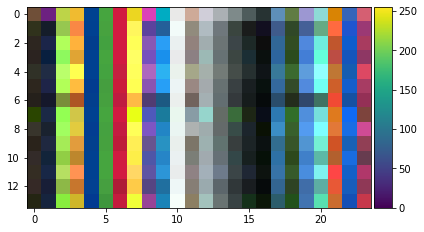

In [49]:
res = eval_result(os.path.join(imdir,"result"), 'gt.jpg')

In [50]:
res

,mean,std
1,10.299296,6.699830
2,5.150585,2.498223
3,7.324760,1.960212
4,6.937075,3.892775
5,13.948867,1.948460
6,5.706694,1.957145
7,13.869025,3.912717
8,9.717129,1.256078
9,6.540668,2.360985
10,24.832455,3.643852


In [43]:
with open(os.path.join(os.path.join(imdir,"resultb"),"images.json")) as f:
    j=json.load(f)

In [18]:
np.degrees(np.arccos((normalize(np.array([1, 2, 3]))*normalize(np.array([4, 5, 6]))).sum()))

12.933154491899135

D:\Program Files\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


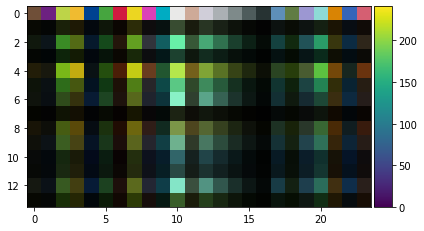

In [51]:
orig_diff = eval_result(os.path.join(imdir,"orig"), 'gt.jpg')

In [52]:
orig_diff

,mean,std
1,16.506115,4.427546
2,13.994486,3.404472
3,12.324448,4.928144
4,11.326036,4.702201
5,15.723491,3.333442
6,14.255930,4.618845
7,10.080888,4.947492
8,9.213509,4.847980
9,14.283433,2.603627
10,30.253817,4.041584


In [67]:
#pd.DataFrame({"original": orig_diff, "NCB-XYZ": res, "NCB-Bradford": res2})
pd.concat({"original": orig_diff, "NCB-XYZ": res, "NCB-Bradford": res2}, axis=1)

original              NCB-XYZ           NCB-Bradford          
         mean       std       mean       std         mean       std
1   16.506115  4.427546  10.299296  6.699830     7.496292  7.005528
2   13.994486  3.404472   5.150585  2.498223     2.824718  2.256745
3   12.324448  4.928144   7.324760  1.960212     5.835723  1.845949
4   11.326036  4.702201   6.937075  3.892775     4.997954  4.071316
5   15.723491  3.333442  13.948867  1.948460    11.937199  2.167273
6   14.255930  4.618845   5.706694  1.957145     4.399494  2.167435
7   10.080888  4.947492  13.869025  3.912717    14.178818  3.887305
8    9.213509  4.847980   9.717129  1.256078     8.963187  1.446930
9   14.283433  2.603627   6.540668  2.360985     6.627015  2.362526
10  30.253817  4.041584  24.832455  3.643852    23.302247  3.567260
11  11.927574  5.192520   7.559805  2.801417     5.316066  2.505603
12   7.803104  4.464811   6.136940  3.235413     7.051953  3.973295
13  11.778715  6.206339   0.946292  0.803414     0.761726  0.808756
14   7.583483  2.382017   0.589524  0.445822     2.586995  0.356185
15  19.831452  4.611277   0.829292  0.639166     1.943909  0.526174
16   9.487981  5.206523   8.036334  1.605784     7.470587  1.951761
17  22.983175  3.244467  18.252177  5.648324    15.512373  5.781195
18  13.050720  6.254792  11.205636  1.653566    12.027975  1.658330
19  15.341474  3.443546   0.801215  0.311628     2.483761  0.293354
20  16.041089  3.665375   2.802166  1.868723     2.234671  1.174862
21  15.294803  3.610521   1.952381  0.954412     2.027761  0.874407
22  15.078716  3.916871   3.365866  4.145728     3.469576  3.710379
23  15.290026  5.664042   6.195693  5.222158     5.389604  5.263547
24  15.053189  8.011454  11.897809  8.099866    10.860061  7.846308